In [12]:
from data.loader import HAM10000Dataset
from data.transforms import get_transform
from models.adaptive_activation import AdaptiveActivation, ParametricActivation
from models.autoencoder import Autoencoder
import torch
import torch.optim as optim
import os
from torch import nn
from utils.training import load_checkpoint


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

activation = torch.load('pre_act/activation.pth')

root_path = 'outputs'
encoder_name = 'autoencoder'
model = Autoencoder(input_channels=3, activation=activation, 
                    parametric_activation=True, device=device).to(device)
optimizer = optim.Adam(model.parameters())
checkpoint_filename = os.path.join(root_path, 'checkpoints', f'{encoder_name}_checkpoint.pth')
start_epoch, saved_loss = load_checkpoint(model, optimizer, checkpoint_filename)

C:\Users\The_Boss\AppData\Local\Temp\ipykernel_8320\2410749768.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activation = torch.load('pre_act/activation.pth')


Early stopping at epoch 20717 - No improvement for 100 epochs
Checkpoint loaded from outputs\checkpoints\autoencoder_checkpoint.pth


d:\Learnable_Activation\utils\training.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


In [13]:
from models.fit_activation import fit_activation_parameters
parameters = fit_activation_parameters(activation, num_epochs=100000)
print(parameters)


Early stopping at epoch 22416 - No improvement for 100 epochs
(0.13434047996997833, -0.09549027681350708, 1.002097487449646, -0.05340568721294403, -0.047184478491544724, 80.84105682373047)


In [14]:
class AutoencoderParametric(nn.Module):
    def __init__(self, input_channels=1, parameters=None, device='cuda'):
        super(AutoencoderParametric, self).__init__()

        if parameters is None:
            raise ValueError("Parameters are not provided")
        
        self.parametric_activation = ParametricActivation(parameters).to(device)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, stride=2, padding=1),
            self.parametric_activation,
            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
            self.parametric_activation
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.parametric_activation,
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            self.parametric_activation,
            nn.Conv2d(16, input_channels, kernel_size=3, stride=1, padding=1),
            self.parametric_activation,
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
# Create the new ReLU model
parameters = (0.13440139591693878, -0.09541631489992142, 1.0021055936813354, -0.053388383239507675, -0.046685654670000076, 69.15345001220703)
# model_relu = AutoencoderParametric(input_channels=3, parameters=parameters).to(device)

# # Transfer weights from first encoder (or you could average all encoders if preferred)
# # Transfer Conv2d layers (index 0 and 2 in the Sequential)
# model_relu.encoder[0].load_state_dict(model.encoders[0][0].state_dict())
# model_relu.encoder[2].load_state_dict(model.encoders[0][2].state_dict())

# # For decoder (same as before)
# model_relu.decoder[0].load_state_dict(model.decoder[0].state_dict())
# model_relu.decoder[2].load_state_dict(model.decoder[2].state_dict())
# model_relu.decoder[4].load_state_dict(model.decoder[4].state_dict())

# optimizer = optim.Adam(model_relu.parameters())

# checkpoint = {
#     'epoch': 0,
#     'model_state_dict': model_relu.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': 0,
# }
# torch.save(checkpoint, 'outputs/checkpoints/autoencoder_relu_checkpoint.pth')

In [16]:
# Load the checkpoint from relu model
encoder_name = 'autoencoder_relu'
model = AutoencoderParametric(input_channels=3, parameters=parameters).to(device)
optimizer = optim.Adam(model.parameters())
checkpoint_filename = os.path.join(root_path, 'checkpoints', f'{encoder_name}_checkpoint.pth')
start_epoch, saved_loss = load_checkpoint(model, optimizer, checkpoint_filename)
print(start_epoch, saved_loss)

Checkpoint loaded from outputs\checkpoints\autoencoder_relu_checkpoint.pth
5 0.0015548347988958234


In [17]:
class EncoderClassifier(nn.Module):
    def __init__(self, encoder, num_classes=170, parameters=None):
        super(EncoderClassifier, self).__init__()
        self.encoder = encoder.encoder

        if parameters is None:
            raise ValueError("Parameters are not provided")
        
        self.parametric_activation = ParametricActivation(parameters).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 8 * 8, 1024),  # Increased capacity
            self.parametric_activation,
            nn.BatchNorm1d(1024),  # Added BatchNorm
            nn.Dropout(0.3),  # Reduced dropout
            nn.Linear(1024, 512),
            self.parametric_activation,
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.encoder(x)
        output = self.classifier(features)
        return output

classifier = EncoderClassifier(model, parameters=parameters).to(device)

for param in classifier.encoder.parameters():
    param.requires_grad = False

optimizer_classifier = optim.Adam(classifier.classifier.parameters(), lr=0.001)

# Loss function for classification
criterion = nn.CrossEntropyLoss()

# Save initial checkpoint
checkpoint = {
    'epoch': 0,
    'model_state_dict': classifier.state_dict(),
    'optimizer_state_dict': optimizer_classifier.state_dict(),
    'loss': 0,
}
torch.save(checkpoint, 'classifier_checkpoint.pth')


ValueError: Parameters are not provided

In [7]:
from data.loader import HAM10000Dataset
from data.transforms import get_transform
from torch.utils.data import DataLoader

t_transform = get_transform(train=True)
v_transform = get_transform(train=False)

train_dataset = HAM10000Dataset(root_path='D:/Learnable_Activation/datasets/HAM10000', transform=t_transform, split='train')
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = HAM10000Dataset(root_path='D:/Learnable_Activation/datasets/HAM10000', transform=v_transform, split='test')
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3785649..1.4485881].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18346393..1.8135487].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25794095..1.5382922].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.279031..1.7378736].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3690777..1.3172023].


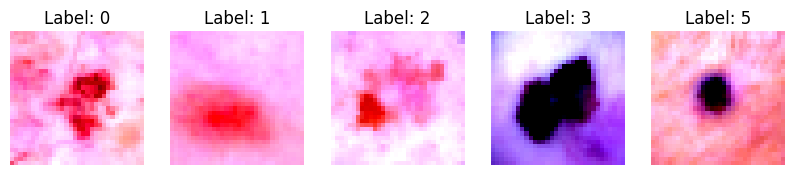

In [8]:
import matplotlib.pyplot as plt

def display_images(loader):
    images, labels = next(iter(loader))
    unique_labels = torch.unique(labels)  # Get unique labels

    images = images.permute(0, 2, 3, 1).numpy()  # Change shape to (batch_size, height, width, channels)

    plt.figure(figsize=(10, 5))
    for i in range(min(5, len(unique_labels))):  # Display up to 5 unique labels
        label = unique_labels[i].item()
        indices = (labels == label).nonzero(as_tuple=True)[0]  # Get indices of images with the current unique label
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[indices[0]])  # Display the first image with the current unique label
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

display_images(test_loader)


In [9]:
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np


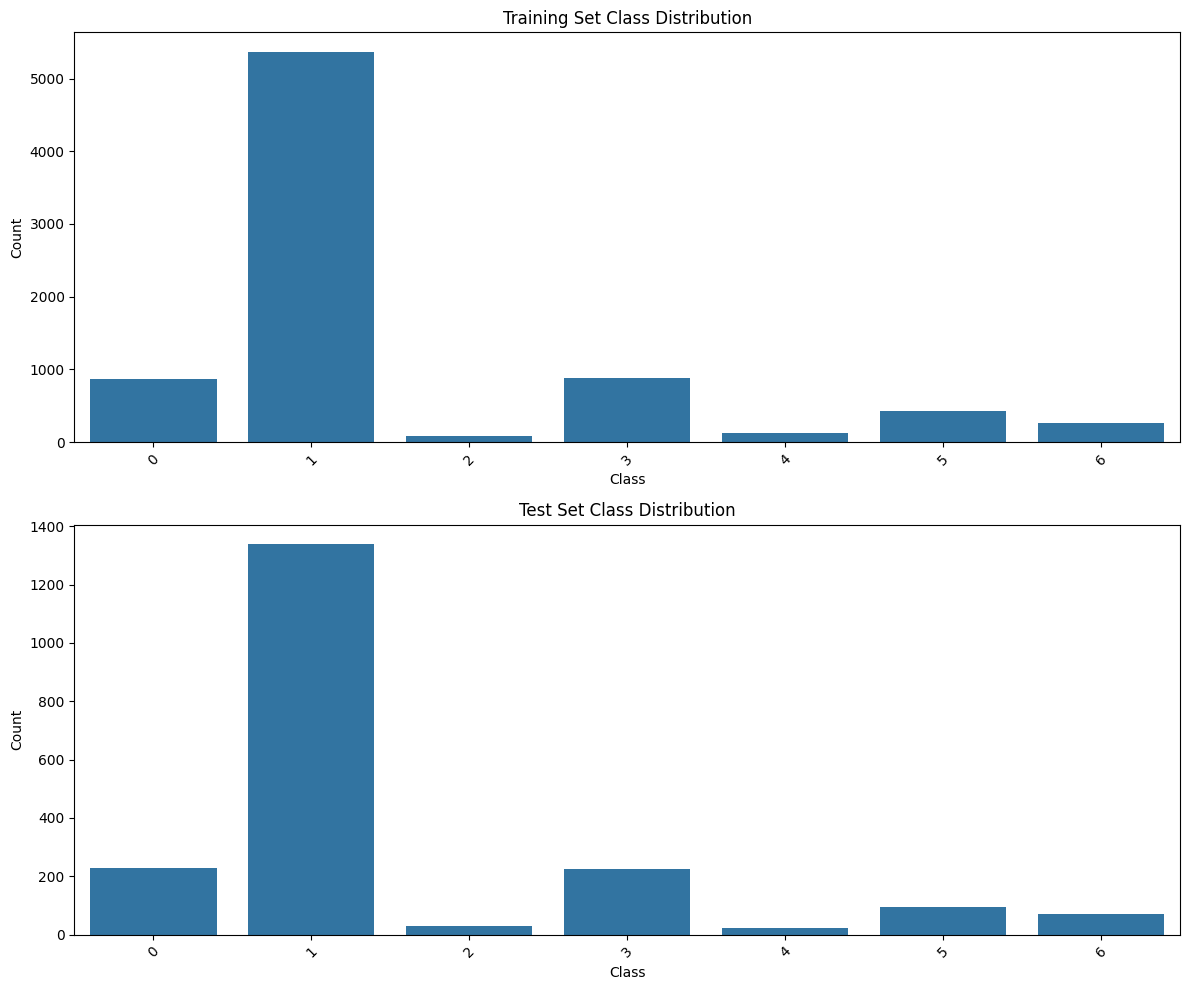


Training Set Statistics:
Total samples: 8012

Class distribution:
Class 1: 5367 samples (66.99%)
Class 3: 887 samples (11.07%)
Class 0: 871 samples (10.87%)
Class 5: 421 samples (5.25%)
Class 6: 258 samples (3.22%)
Class 4: 121 samples (1.51%)
Class 2: 87 samples (1.09%)

Test Set Statistics:
Total samples: 2003

Class distribution:
Class 1: 1338 samples (66.80%)
Class 0: 228 samples (11.38%)
Class 3: 226 samples (11.28%)
Class 5: 93 samples (4.64%)
Class 6: 69 samples (3.44%)
Class 2: 28 samples (1.40%)
Class 4: 21 samples (1.05%)


In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Analyze training set distribution
train_labels = []
for _, labels in train_loader:
    train_labels.extend(labels.numpy())

test_labels = []
for _, labels in test_loader:
    test_labels.extend(labels.numpy())

# Convert to pandas Series for easier plotting
train_dist = pd.Series(train_labels).value_counts()
test_dist = pd.Series(test_labels).value_counts()

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot training distribution
sns.barplot(x=train_dist.index, y=train_dist.values, ax=ax1)
ax1.set_title('Training Set Class Distribution')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Plot test distribution
sns.barplot(x=test_dist.index, y=test_dist.values, ax=ax2)
ax2.set_title('Test Set Class Distribution')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print("\nTraining Set Statistics:")
print(f"Total samples: {len(train_labels)}")
print("\nClass distribution:")
for class_idx, count in train_dist.items():
    percentage = (count / len(train_labels)) * 100
    print(f"Class {class_idx}: {count} samples ({percentage:.2f}%)")

print("\nTest Set Statistics:")
print(f"Total samples: {len(test_labels)}")
print("\nClass distribution:")
for class_idx, count in test_dist.items():
    percentage = (count / len(test_labels)) * 100
    print(f"Class {class_idx}: {count} samples ({percentage:.2f}%)")

In [11]:
# Calculate class weights
def compute_class_weights(labels, num_classes=170):
    counts = {i: 0 for i in range(num_classes)}
    
    label_counts = Counter(labels)
    counts.update(label_counts)
    total = len(labels)
    
    weights = {}
    for label in range(num_classes):
        count = counts[label]
        if count == 0:
            weights[label] = 1.0
        else:
            weights[label] = total / (num_classes * count)
    
    return weights

# Get class weights
train_weights = compute_class_weights(train_labels, num_classes=170) # For expanability
class_weights = torch.FloatTensor([train_weights[i] for i in range(len(train_weights))]).to(device)

# Training function
def train_classifier(model, train_loader, test_loader, class_weights, num_epochs=50, device='cuda'):
    criterion = nn.CrossEntropyLoss(weight=class_weights)  # Use weighted loss
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    best_accuracy = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_preds = []
        train_labels = []
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        # Calculate training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_labels, train_preds, average='weighted'
        )
        
        # Evaluation phase
        model.eval()
        test_preds = []
        test_labels = []
        
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                test_preds.extend(predicted.cpu().numpy())
                test_labels.extend(labels.numpy())
        
        # Calculate test metrics
        test_accuracy = accuracy_score(test_labels, test_preds)
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
            test_labels, test_preds, average='weighted'
        )
        
        # Update scheduler based on test accuracy
        scheduler.step(test_accuracy)
        
        # Save best model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': best_accuracy,
            }, 'best_classifier.pth')
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {running_loss/len(train_loader):.4f}')
        print(f'Train Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}')
        print(f'Test Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}')
        print('-' * 50)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier.to(device)
# Train with class weights
train_classifier(classifier, train_loader, test_loader, class_weights, num_epochs=50, device=device)

c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50]
Train Loss: 4.3937
Train Accuracy: 0.1741, F1: 0.2248
Test Accuracy: 0.5332, F1: 0.5484
--------------------------------------------------


c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/50]
Train Loss: 2.6477
Train Accuracy: 0.3145, F1: 0.3857
Test Accuracy: 0.4488, F1: 0.4874
--------------------------------------------------


c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/50]
Train Loss: 2.1342
Train Accuracy: 0.2534, F1: 0.3248
Test Accuracy: 0.4873, F1: 0.5208
--------------------------------------------------


c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/50]
Train Loss: 2.0669
Train Accuracy: 0.2335, F1: 0.2995
Test Accuracy: 0.3689, F1: 0.4614
--------------------------------------------------


c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/50]
Train Loss: 2.0271
Train Accuracy: 0.2245, F1: 0.2929
Test Accuracy: 0.4294, F1: 0.4984
--------------------------------------------------
Epoch [6/50]
Train Loss: 2.0106
Train Accuracy: 0.2257, F1: 0.2962
Test Accuracy: 0.3560, F1: 0.4403
--------------------------------------------------


c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/50]
Train Loss: 1.9845
Train Accuracy: 0.2526, F1: 0.3259
Test Accuracy: 0.2546, F1: 0.2679
--------------------------------------------------
Epoch [8/50]
Train Loss: 1.9583
Train Accuracy: 0.2227, F1: 0.2879
Test Accuracy: 0.4818, F1: 0.5307
--------------------------------------------------
Epoch [9/50]
Train Loss: 1.9460
Train Accuracy: 0.2510, F1: 0.3201
Test Accuracy: 0.4638, F1: 0.5108
--------------------------------------------------


c:\Users\The_Boss\.conda\envs\UNI_GPT\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/50]
Train Loss: 1.9550
Train Accuracy: 0.2408, F1: 0.3025
Test Accuracy: 0.4898, F1: 0.5397
--------------------------------------------------
Epoch [11/50]
Train Loss: 1.9563
Train Accuracy: 0.2309, F1: 0.2966
Test Accuracy: 0.4059, F1: 0.4596
--------------------------------------------------
Epoch [12/50]
Train Loss: 1.9459
Train Accuracy: 0.2384, F1: 0.3025
Test Accuracy: 0.3535, F1: 0.4262
--------------------------------------------------
Epoch [13/50]
Train Loss: 1.9354
Train Accuracy: 0.2312, F1: 0.2948
Test Accuracy: 0.3989, F1: 0.4740
--------------------------------------------------


KeyboardInterrupt: 